<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula05e_hard_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

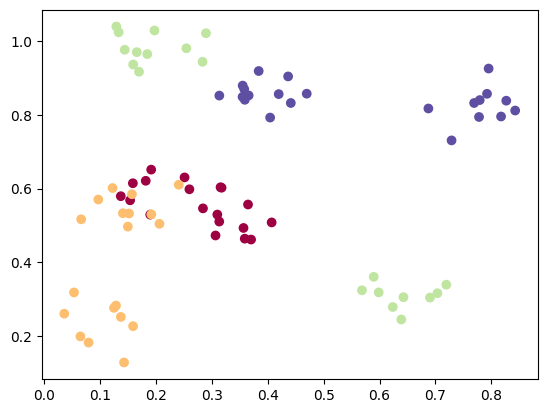

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


def plot_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    return plt


def plot_hiperplano(vector, intercept):
  xs = np.array([0, 1])
  ys = -(vector[0] * xs + intercept) / vector[1]
  plt.plot(xs, ys, '-')


def make_multiclass_dataset(n=100, n_classes=4):
  X, y = make_blobs(n_samples=n,
                     centers=n_classes*2,
                     center_box=(0,1),
                     cluster_std=0.05)
  y = y % n_classes
  return X, y


def define_axes(X, offset):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]


def plot_predictions(clf, X, offset = 0.5):
    axes = define_axes(X, offset)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


X, y = make_multiclass_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
_ = plot_dataset(X_train, y_train)

In [166]:
import numpy as np

def include_bias(X):
  bias = np.ones((X.shape[0],1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Backpropagation():
  def __init__(self, n_hidden=[2], max_iter=1000, learning_rate=0.01):
    self.n_hidden = n_hidden
    self.max_iter = max_iter
    self.learning_rate = learning_rate

  def foward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = np.tanh(self.Z[-1])
    return AUX

  def backward(self, y, ypred):
    grads = []
    output_delta = y - ypred
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      tanh_grad = (1 - np.tanh(self.Z[i-1])**2)
      input_delta = (output_delta @ self.Ws[i][1:, :].T) * tanh_grad
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()
    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] += grads[i] * self.learning_rate

  def get_ws(self, X, y):
    self.Ws = []
    previous_output = X.shape[1]
    for n in self.n_hidden:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, n)))
      previous_output = n
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, y.shape[1])))
    for _ in range(self.max_iter):
      ypred = self.foward(X)
      self.backward(y, ypred)
    return self.Ws

1.0


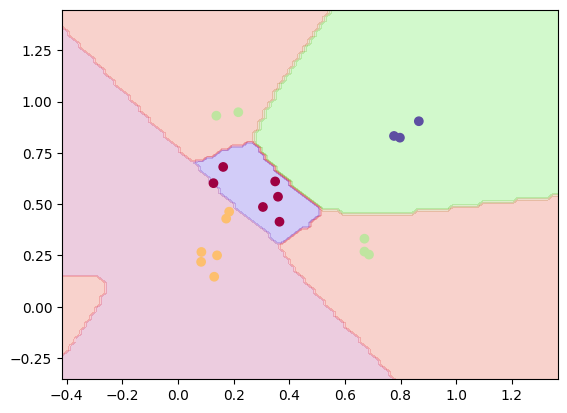

In [169]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

def sign(x):
  return np.sign(x)

class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=Backpropagation()):
    self.training_algorithm = training_algorithm

  def fit(self, X, y):
    self.lb = LabelBinarizer()
    y = self.lb.fit_transform(y)
    y = y * 2 - 1
    self.w = self.training_algorithm.get_ws(X, y)
    return self

  def predict(self, X):
    ypred = self.training_algorithm.foward(X)
    return self.lb.inverse_transform(ypred)

model = MLP(Backpropagation([5]))
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plot_predictions(model, X_test)
plot_dataset(X_test, y_test)
plt.show()